# Speech enhancement by Wiener filtering 


# 1. Introduction
The main speech enhancement algorithms can be divided in three main classes:
- Spectral-subtractive algorithms, that aim to estimate the noise spectrum and simply subtract it from the full spectrum
- Statistical-model-based algorithms, that aim to estimate relevant parameters of the clean speech by measurement on the noisy speech, and to use these parameters to reconstruct the clean speech
- Subspace methods, that assumes the clean speech lies in a subspace of a larger "noisy speech" space, and determine this subspace by linear algebra methods
I will focus on a particular method in the second class, called Iterative Wiener Filtering.

# 2. Denoising

In [12]:
import speech as sp
import IPython
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import speech as sp
import IPython

speech_file = '../samples/speech_male/arctic_a0001.wav'
noise_file = '../samples/noise/crowd.wav' # Leave empty for adding generated white noise instead
snr_vals = [10]
p = 10 #Order of the all pole filter
frame_size = 400 # Window size for the STFT
iterations = 5 # Number of iterations to compute the Wiener Filter
alpha = 0.05 # Parameter of the sigma update in the VAD

#Initialize outputs
s = [None]*len(snr_vals)
s_VAD = [None]*len(snr_vals)
voice_activity = [None]*len(snr_vals)
sigma_tracking = [None]*len(snr_vals)
# Load the clean speech sample
y_clean, sr = sp.data.load(speech_file)

for i,SNR in enumerate(snr_vals):
    print('SNR = {}'.format(SNR))
    # Add noise to the speech, at requested SNR
    if(noise_file == ''):
        y = sp.data.add_white_noise(y_clean,SNR)
    else:
        y = sp.data.add_noise_from_file(y_clean,sr,'../samples/noise/crowd.wav',SNR)
    # Denoising only
    print('    Denoising...')
    s[i] = sp.process.denoise(y,frame_size,p,iterations)
    # VAD + Denoising
    print('    Denoising with VAD...')
    s_VAD[i],voice_activity[i],sigma_tracking[i] = sp.process.denoise_with_vad(y,sr,frame_size,p,iterations,alpha)


print('Done!')

SNR = 10
    Denoising...
    Denoising with VAD...
Done!


In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def plot_signal(signal):
    fig,(ax0,ax1) = plt.subplots(nrows = 1, ncols=2,figsize=(16,4))
    t = np.arange(len(signal))/sr
    
    ax0.plot(t,signal)
    ax0.set_xlabel('Time[s]')
    ax0.set_ylabel('Normalized amplitude')
    ax0.set_title('Signal')
    _,_,_,cax = ax1.specgram(signal,NFFT=frame_size,Fs = sr)
    ax1.set_xlabel('Time[s]')
    ax1.set_ylabel('Frequency [Hz]')
    ax1.set_title('Spectrogram')
    cbar = plt.colorbar(cax)
    cbar.set_label('Amplitude [dB]')
    IPython.display.display(IPython.display.Audio(signal,rate=sr))

def plot_SNR(s):    
    time_SNR = sp.evaluate.time_SNR(y,s,frame_size)
    t = np.arange(len(s))/sr
    true_SNR = sp.evaluate.time_SNR(y,y_clean,200)
    post_SNR = sp.evaluate.time_SNR(y,s,200)

    fig = plt.figure(figsize=(6,4))
    plt.plot(true_SNR,label='True SNR')
    plt.plot(post_SNR,label='A posteriori SNR')
    plt.xlabel('Time [s]')
    plt.ylabel('SNR [dB]')
    plt.legend()
    return fig

def plot_VAD(voice_activity,sigma_tracking):
    fig,(ax0,ax1) = plt.subplots(nrows = 1, ncols = 2,figsize=(16,4))
    ax0.plot(voice_activity)
    ax0.set_xlabel('Frame')
    ax0.set_ylabel('Noise (0) or speech (1)')
    ax0.set_title('Voice activity')
    
    ax1.plot(sigma_tracking)
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('$\sigma_n$')
    ax1.set_title('Noise estimation')
    
    return fig

The following figures present the sound file, the time signal and the spectrogram for respectively :
> 1. The input noisy signal
> 2. The signal obtained by simple denoising
> 3. The signal obtained by VAD + denoising
> 4. The actual clean signal

SNR = 10 dB, noisy signal


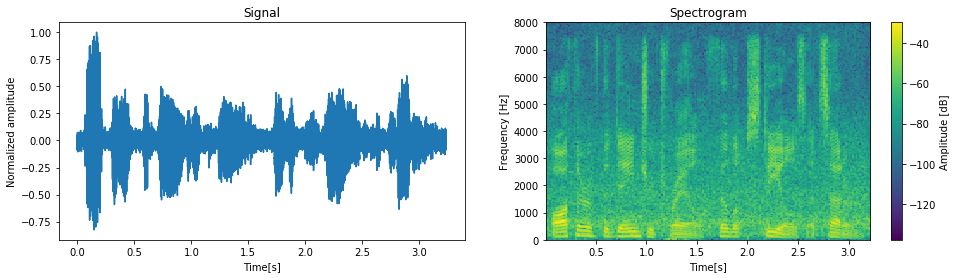

In [4]:
print('SNR = 10 dB, noisy signal')
plot_signal(y)

SNR = 10 dB, no VAD
A posteriori SNR = 


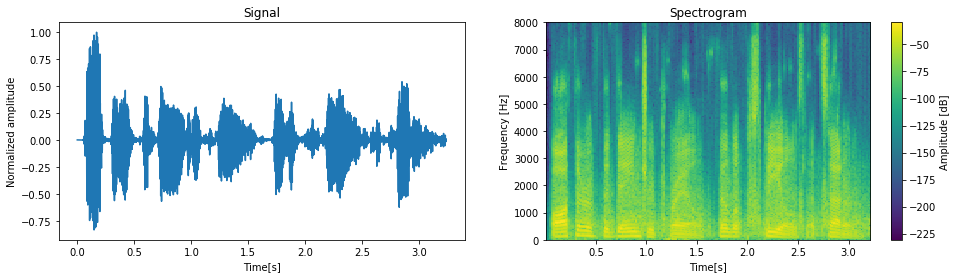

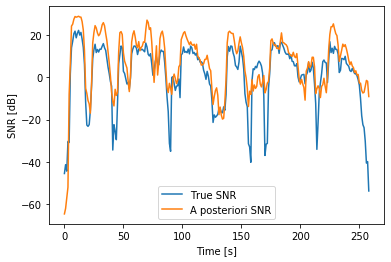

In [5]:
print('SNR = 10 dB, no VAD')
print('A posteriori SNR = '.format(sp.evaluate.SNR(y,s[0])))
plot_signal(s[0])
snr_fig = plot_SNR(s[0])

SNR = 10 dB, VAD


A posteriori SNR = 


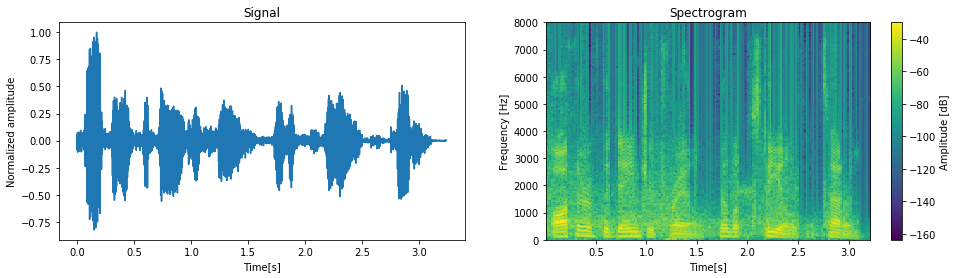

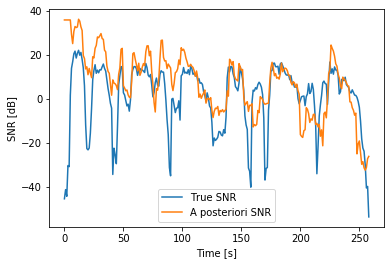

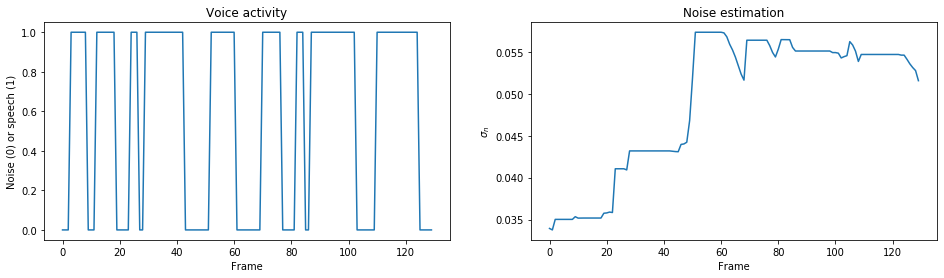

In [6]:
print('SNR = 10 dB, VAD')
plot_signal(s_VAD[0])
print('A posteriori SNR = '.format(sp.evaluate.SNR(y,s_VAD[0])))
snr_fig = plot_SNR(s_VAD[0])
vad_fig = plot_VAD(voice_activity[0],sigma_tracking[0])

SNR = 10 dB, exact clean signal


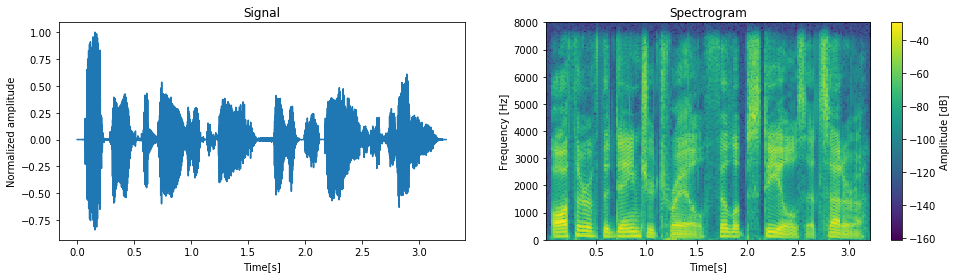

In [7]:
print('SNR = 10 dB, exact clean signal')
plot_signal(y_clean)

We observe that perceptually the denoising procedure seem to work.
In the VAD case some artefacts are however created.

Moreover both the global SNR and the framewise SNR are in general slightly improved by both approaches.